In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import cv2
import os
import random

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
import tensorflow as tf
import tensorflow.keras as keras


In [4]:
tf.__version__

'2.8.0'

In [5]:
tf.random.set_seed(42)
np.random.seed(42)


In [6]:
train_dir = "/content/gdrive/MyDrive/AGCCPF/train"
test_dir = "/content/gdrive/MyDrive/AGCCPF/test"
valid_dir = "/content/gdrive/MyDrive/AGCCPF/validate"


In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

valid_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=False
        )

Found 5253 images belonging to 3 classes.
Found 1315 images belonging to 3 classes.
Found 1644 images belonging to 3 classes.


In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [11]:
from tensorflow.keras import optimizers

In [12]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(
                  include_top=False,
                  input_shape=(224, 224, 3))


# conv_base = EfficientNetB7(weights='imagenet',
#                   include_top=False,
#                   input_shape=(150, 150, 3))

# conv_base = DenseNet121(weights='imagenet',
#                   include_top=False,
#                   input_shape=(150, 150, 3))

# conv_base = MobileNet(weights='imagenet',
#                   include_top=False,
#                   input_shape=(150, 150, 3))

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))



In [15]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [16]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [17]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/gdrive/MyDrive/model.h5", save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True)


In [18]:
model.summary(0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 21,138,243
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(train_generator,
                    steps_per_epoch=260,
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=60,
                    callbacks=[checkpoint_cb])


Epoch 1/50
260/260 [==============================] - 137s 473ms/step - loss: 0.9952 - acc: 0.5203 - recall: 0.3846 - precision: 0.5344 - val_loss: 0.9935 - val_acc: 0.5008 - val_recall: 0.4383 - val_precision: 0.5152
Epoch 2/50
260/260 [==============================] - 119s 457ms/step - loss: 0.9547 - acc: 0.5392 - recall: 0.3978 - precision: 0.5640 - val_loss: 0.9492 - val_acc: 0.5433 - val_recall: 0.4950 - val_precision: 0.5630
Epoch 3/50
260/260 [==============================] - 119s 458ms/step - loss: 0.9193 - acc: 0.5602 - recall: 0.4235 - precision: 0.5907 - val_loss: 0.9282 - val_acc: 0.5558 - val_recall: 0.5208 - val_precision: 0.5782
Epoch 4/50
260/260 [==============================] - 119s 457ms/step - loss: 0.8966 - acc: 0.5658 - recall: 0.4431 - precision: 0.6123 - val_loss: 0.8783 - val_acc: 0.5775 - val_recall: 0.4133 - val_precision: 0.6640
Epoch 5/50
260/260 [==============================] - 118s 452ms/step - loss: 0.8659 - acc: 0.5852 - recall: 0.4660 - precision:

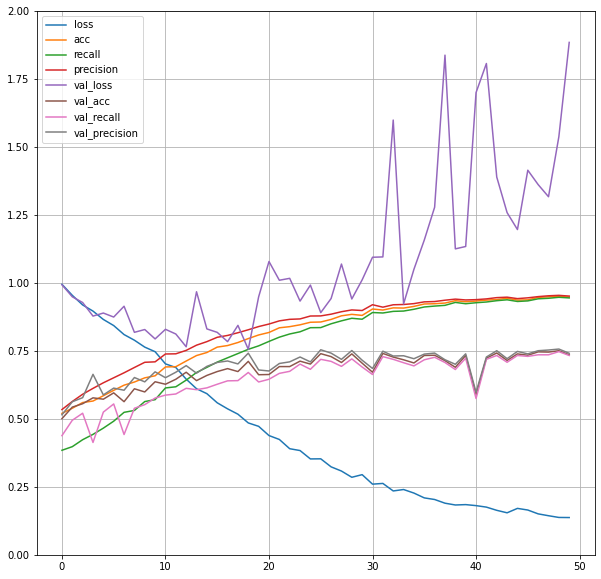

In [20]:
pd.DataFrame(history.history).plot(figsize=(10, 10))
plt.ylim((0,2))
plt.grid(True)
plt.show()

In [21]:
model.evaluate(test_generator)

83/83 [==============================] - 14s 163ms/step - loss: 1.8036 - acc: 0.7457 - recall: 0.7439 - precision: 0.7498


[1.8035876750946045,
 0.7457420825958252,
 0.7439172863960266,
 0.7498466968536377]

In [22]:
x=model.predict(test_generator)
actual=test_generator.labels
pred=np.argmax(x, axis=1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[170,  99,  19],
       [ 17, 792,  61],
       [ 15, 207, 264]])